## Imports

In [659]:
import pandas as pd
import requests
from urllib.request import Request, urlopen    
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from datetime import datetime
import math
import matplotlib.pyplot  as plt
import tabula
from tabula.io import read_pdf



# Acquisition

### Helper functions

In [660]:
#A function that returns a dataframe of all the historic data of a given ticker. 
def get_yfinance_data(ticker):
	url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=994016928&period2=1642982400&interval=1d&events=history&includeAdjustedClose=true'

	data = pd.read_csv(url)

	return data

### Retrieval

In [661]:
#Get crypto historic prices
df_btc_usd = get_yfinance_data('BTC-USD')
df_eth_usd = get_yfinance_data('ETH-USD')
df_sol_usd = get_yfinance_data('SOL1-USD')
df_ada_usd = get_yfinance_data('ADA-USD')
df_doge_usd = get_yfinance_data('DOGE-USD')
df_xrp_usd = get_yfinance_data('XRP-USD')


In [662]:
crypto_dfs = [df_sol_usd, df_ada_usd, df_doge_usd, df_eth_usd, df_xrp_usd]

In [663]:
#Get SOXX historic prices
df_soxx = get_yfinance_data('SOXX')

In [664]:
#Get Crude oil prices
df_oil = get_yfinance_data('CL=F')

In [665]:
#Get cloud companies (server providers) ETF prices
df_servers = get_yfinance_data('SKYY')

In [666]:
#Get US wildfires
df_wildfires = pd.read_csv("https://www.ncdc.noaa.gov/societal-impacts/wildfires/ytd/0/data.csv", skiprows=1)

In [667]:
df_divorce = tabula.read_pdf('https://www.cdc.gov/nchs/data/dvs/national-marriage-divorce-rates-00-19.pdf', pages=1)[0]

In [668]:
#Get Nicolas Cage data
url = 'https://imdb-api.com/API/Name/k_vt8o65n8/nm0000115'
resp = requests.get(url)
nc_data = resp.json()
df_nicolas = pd.DataFrame(nc_data['castMovies'])


In [682]:
#air quality date
# source https://www.oecd-ilibrary.org/environment/air-and-ghg-emissions/indicator/english_93d10cf7-en?parentId=http%3A%2F%2Finstance.metastore.ingenta.com%2Fcontent%2Fthematicgrouping%2F0349afa1-en

df_airQ = pd.read_csv('datasets/DP_LIVE_05022022011407397.csv')


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,AIREMISSION,CO2,TONNE_CAP,A,2000,17.59,NaN
1,AUS,AIREMISSION,CO2,TONNE_CAP,A,2001,17.69,NaN
2,AUS,AIREMISSION,CO2,TONNE_CAP,A,2002,17.90,NaN
3,AUS,AIREMISSION,CO2,TONNE_CAP,A,2003,17.65,NaN
4,AUS,AIREMISSION,CO2,TONNE_CAP,A,2004,18.13,NaN
...,...,...,...,...,...,...,...,...
2998,EU27_2020,AIREMISSION,CO2,TONNE_CAP,A,2016,6.36,NaN
2999,EU27_2020,AIREMISSION,CO2,TONNE_CAP,A,2017,6.39,NaN
3000,EU27_2020,AIREMISSION,CO2,TONNE_CAP,A,2018,6.24,NaN
3001,EU27_2020,AIREMISSION,CO2,TONNE_CAP,A,2019,5.92,NaN


# Preprocessing

### Helper functions

In [669]:
#Function that returns the oldest data from a list of data frames. 
def str_to_datetime(dataframes, date_column):
	for df in dataframes:
		df[date_column] = pd.to_datetime(df[date_column]).dt.date

#Function that returns the first date of the "youngest" of dataframes
def get_min_possible_date(dataframes, date_column):

	return max([min(dataframe[date_column]) for dataframe in dataframes])


#DONT USE, Function that returns the oldest date along with the name of the df that contains it
def get_oldest_df(dataframes, date_column):
	ol_date = (get_min_possible_date(dataframes, date_column), 42)
	for i, df in enumerate(dataframes):
		first_entry = min(df[date_column])
		if first_entry < ol_date[0]:
			ol_date = (first_entry, i)
	
	return ol_date[0], dataframes[ol_date[1]]

def clear_years(data): ## remove extra note on year strings
	if len(data) > 4:
		data = data[0:4]

	return data

### Crypto Index

In [670]:
#Turn Date columns from str to datetime format
# str_to_datetime(crypto_dfs, 'Date')

We know that bitcoin is the oldest cryptocurrency so we can calculate the index with it as a base

In [671]:
#Clean data to just the variables we need
df_btc_usd = df_btc_usd[['Date', 'Close', 'Volume']].rename({'Close': 'BTC_price', 'Volume': 'BTC_vol'}, axis=1)
df_eth_usd = df_eth_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ETH_price', 'Volume': 'ETH_vol'}, axis=1)
df_sol_usd = df_sol_usd[['Date', 'Close', 'Volume']].rename({'Close': 'SOL_price', 'Volume': 'SOL_vol'}, axis=1)
df_ada_usd = df_ada_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ADA_price', 'Volume': 'ADA_vol'}, axis=1)
df_doge_usd = df_doge_usd[['Date', 'Close', 'Volume']].rename({'Close': 'DOGE_price', 'Volume': 'DOGE_vol'}, axis=1)
df_xrp_usd = df_xrp_usd[['Date', 'Close', 'Volume']].rename({'Close': 'XRP_price', 'Volume': 'XRP_vol'}, axis=1)


In [672]:
#Create new Dataframe inlcuding all cryptocurrencies closing prices and volumes
cr_index = df_btc_usd
cr_index = cr_index.merge(df_eth_usd, on='Date', how='left')
cr_index = cr_index.merge(df_ada_usd, on='Date', how='left')
cr_index = cr_index.merge(df_xrp_usd, on='Date', how='left')
cr_index = cr_index.merge(df_doge_usd, on='Date', how='left')
cr_index = cr_index.merge(df_sol_usd, on='Date', how='left')

In [673]:
#Turn "Date" column to datetime format instead of str
str_to_datetime([cr_index], 'Date')

#Fill NaNs with 0
cr_index = cr_index.fillna(0)

#Calculate total trading volume per day
cr_index['tot_volume'] = cr_index[['BTC_vol', 'ETH_vol', 'ADA_vol', 'XRP_vol', 'DOGE_vol', 'SOL_vol']].sum(axis=1)

In [674]:
cr_index.columns

Index(['Date', 'BTC_price', 'BTC_vol', 'ETH_price', 'ETH_vol', 'ADA_price',
       'ADA_vol', 'XRP_price', 'XRP_vol', 'DOGE_price', 'DOGE_vol',
       'SOL_price', 'SOL_vol', 'tot_volume'],
      dtype='object')

In [675]:

def index_calc(df):

	return math.log(sum([(df['BTC_price']*(df['BTC_vol']/df['tot_volume'])),
			  (df['ETH_price']*(df['ETH_vol']/df['tot_volume'])),
			  (df['ADA_price']*(df['ADA_vol']/df['tot_volume'])),
			  (df['XRP_price']*(df['XRP_vol']/df['tot_volume'])),
			  (df['DOGE_price']*(df['DOGE_vol']/df['tot_volume'])),
			  (df['SOL_price']*(df['SOL_vol']/df['tot_volume']))]))

cr_index['Crypto_Index'] = cr_index.apply(index_calc, axis=1)

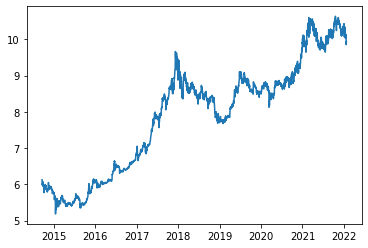

In [676]:
plt.plot(cr_index['Date'], cr_index['Crypto_Index'])


### Other indices

In [677]:
#Finance dataframes to datetime format
df_soxx['Date'] = pd.to_datetime(df_soxx['Date'])
df_oil['Date'] = pd.to_datetime(df_oil['Date'])
df_servers['Date'] = pd.to_datetime(df_servers['Date'])

In [678]:
#Wildfires prep
df_wildfires['Date'] = pd.to_datetime(df_wildfires['Date'], format="%Y%m")

In [679]:
df_divorce.rename(columns=df_divorce.iloc[1], inplace=True) #column names were perceived as a row, turn the into actual column names
df_divorce = df_divorce.iloc[2:, :] # delete first 2 rows of no data
df_divorce = df_divorce.reset_index().drop('index',axis=1) # drop old index after reset
df_divorce['Year'] = df_divorce['Year'].apply(clear_years) #clear year data strings from unwanted extra note
df_divorce.rename(columns={'Year': 'Date'}, inplace=True) # change name for consistency
df_divorce['Date'] = pd.to_datetime(df_divorce['Date'], format='%Y')
df_divorce.replace(',', '', inplace=True, regex=True) #remove commas from number strings so we an turn them into int
df_divorce[['Marriages', 'Population', 'population']] = df_divorce[['Marriages', 'Population', 'population']].apply(pd.to_numeric) #turn str numbers into int



In [680]:
#Nicolas Cage prep
df_nicolas = df_nicolas[df_nicolas['role'] == "Actor"] #Keep only movies where he was an actor
df_nicolas = df_nicolas[['year', 'title', 'description']] # drop redundant columns and change order
df_nicolas = df_nicolas[df_nicolas['year'] != ''] #drop that haven't been released yet
df_nicolas.rename(columns={'year': 'Date'}, inplace=True) #rename year column for consistency
df_nicolas['Date'] = df_nicolas['Date'].apply(clear_years) #Clear years for notes and extra chars
df_nicolas['Date'] = pd.to_datetime(df_nicolas['Date']) #str to datetime for Years column
df_nicolas = df_nicolas.sort_values('Date', ascending=False) #sort new to old
df_nicolas = df_nicolas.reset_index().drop('index',axis=1) # drop old index after reset
df_nicolas = pd.DataFrame(df_nicolas['title'].groupby(df_nicolas['Date']).agg('count') ) #get number of movies per year
df_nicolas.reset_index(inplace=True) #reset the idex for consistency
df_nicolas.rename(columns={'title': 'no. of movies'}, inplace=True) #change name for clarity